In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
cmap = plt.cm.RdBu
plt.style.use("dark_paper")

In [2]:
nsamples = int(1e5)
ntrain = 1000
xP = np.random.multivariate_normal([2,2],np.eye(2),nsamples)
xN = np.random.multivariate_normal([-2,-2],np.eye(2),nsamples)

y = np.concatenate((np.ones(nsamples),-np.ones(nsamples)))
x = np.concatenate((xP,xN))
mask = np.random.permutation(len(x))
xtrain = torch.from_numpy(x[mask][:ntrain]).float()
ytrain = torch.from_numpy(y[mask][:ntrain]).float().view(-1,1)
xval = torch.from_numpy(x[mask][ntrain:]).float()
yval = torch.from_numpy(y[mask][ntrain:]).float().view(-1,1)

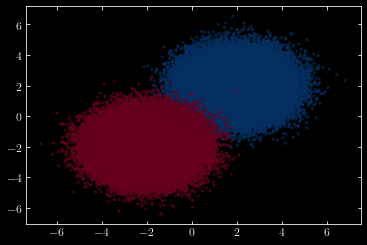

In [3]:
# Visualize data
plt.scatter(*x.T,alpha=0.5,s=5,c=y,cmap=cmap)

In [4]:
# Define simple MLP with 1 hidden layer
mlp = torch.nn.Sequential(torch.nn.Linear(2,3),
                          torch.nn.ReLU(),
                          torch.nn.Linear(3,1))
criterion = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.SGD(mlp.parameters(),lr=1e-2)

In [5]:
# Define training and validation functions
def train(model):
    model.train()
    yhat = model(xtrain)
    loss = criterion(yhat,ytrain.view(-1,1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
def validate(model):
    mlp.eval()
    with torch.no_grad():
        yhat = mlp(xval)
        loss = criterion(yhat,yval.view(-1,1))
        return loss.item()

Epoch 010/100 | Training loss: 0.0907 - Validation loss: 0.0981
Epoch 020/100 | Training loss: 0.0868 - Validation loss: 0.0941
Epoch 030/100 | Training loss: 0.0836 - Validation loss: 0.0907
Epoch 040/100 | Training loss: 0.0809 - Validation loss: 0.0878
Epoch 050/100 | Training loss: 0.0785 - Validation loss: 0.0853
Epoch 060/100 | Training loss: 0.0765 - Validation loss: 0.0831
Epoch 070/100 | Training loss: 0.0747 - Validation loss: 0.0812
Epoch 080/100 | Training loss: 0.0732 - Validation loss: 0.0796
Epoch 090/100 | Training loss: 0.0718 - Validation loss: 0.0781
Epoch 100/100 | Training loss: 0.0706 - Validation loss: 0.0768


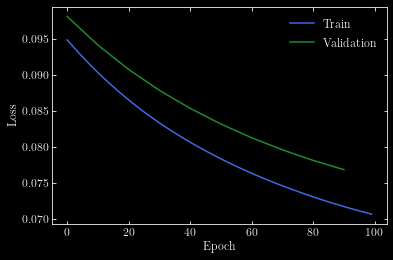

In [9]:
# Train the model for 100 epochs 
T = 100
losses_train = []
losses_val = []
mlp.train()
for t in range(1,T+1):
    loss = train(mlp)
    losses_train.append(loss)
    if t%10 == 0:
        print(f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f}", end=" - ") #,end="\r"
        mlp.eval()
        with torch.no_grad():
            yhat = mlp(xval)
            loss = criterion(yhat,yval.view(-1,1)).item()
        losses_val.append(loss)
        print(f"Validation loss: {loss:^.4f}") #,end="\r"
plt.plot(np.arange(0,T),losses_train,label="Train")
plt.plot(np.arange(0,T,10),losses_val,label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

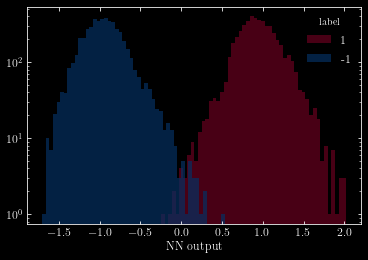

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00     99504
         1.0       1.00      1.00      1.00     99496

    accuracy                           1.00    199000
   macro avg       1.00      1.00      1.00    199000
weighted avg       1.00      1.00      1.00    199000



In [10]:
# Let's take a look at how our model performs
out = classification_report(yval.view(-1).numpy(),np.sign(yhat.view(-1).numpy()))
plt.hist(yhat[yval==1][:5000].numpy(),bins=50,alpha=0.7,color=cmap(0.),label="1")
plt.hist(yhat[yval==-1][:5000].numpy(),bins=50,alpha=0.7,color=cmap(1.),label="-1")
plt.legend(title="label")
plt.yscale("log")
plt.xlabel("NN output")
plt.show()
print(out)

In [8]:
# Now we will print the weights of the hidden layer
modules = list(mlp.modules())
linear1 = modules[1]
print(linear1.weight)

Parameter containing:
tensor([[ 0.1897,  0.2476],
        [-0.1972, -0.3923],
        [-0.2855,  0.6918]], requires_grad=True)
